<a href="https://colab.research.google.com/github/awill139/Demystifying-AI-Course/blob/master/Optimization_and_Regularization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets
import math
np.random.seed(3)

In [0]:
def load_dataset():
    train_X, train_Y = sklearn.datasets.make_moons(n_samples=300, noise=.2) #300 #0.2 
    # Visualize the data
    plt.scatter(train_X[:, 0], train_X[:, 1], c=train_Y.ravel(), s=40, cmap=plt.cm.Spectral);
    train_X = train_X.T
    train_Y = train_Y.reshape((1, train_Y.shape[0]))
    
    return train_X, train_Y

I am sorry, but we will be using a super arbitrary dataset again

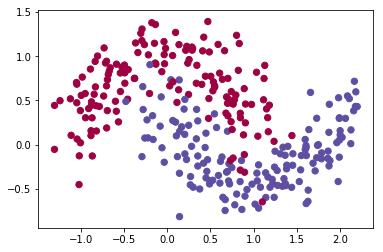

In [0]:
train_X, train_Y = load_dataset()

A couple activation functions

In [0]:
def sigmoid(x):
    s = 1/(1+np.exp(-x))
    return s

def relu(x):
    s = np.maximum(0,x)   
    return s

Now we just want to create a model just as we did before.


In [0]:
def initialize_params(layer_dims):
    

    parameters = {}
    L = len(layer_dims) # number of layers in the network

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1])*  np.sqrt(2 / layer_dims[l-1])
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        
#         assert(parameters['W' + str(l)].shape == layer_dims[l], layer_dims[l-1])
#         assert(parameters['W' + str(l)].shape == layer_dims[l], 1)
        
    return parameters

In [0]:
def compute_cost(a3, Y):
    
    m = Y.shape[1]
    
    logprobs = np.multiply(-np.log(a3),Y) + np.multiply(-np.log(1 - a3), 1 - Y)
    cost = 1./m * np.sum(logprobs)
    
    return cost

In [0]:
def forward_propagation(X, parameters):

    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
    # LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID
    z1 = np.dot(W1, X) + b1
    a1 = relu(z1)
    z2 = np.dot(W2, a1) + b2
    a2 = relu(z2)
    z3 = np.dot(W3, a2) + b3
    a3 = sigmoid(z3)
    
    cache = (z1, a1, W1, b1, z2, a2, W2, b2, z3, a3, W3, b3)
    
    return a3, cache

In [0]:
def backward_propagation(X, Y, cache):

    m = X.shape[1]
    (z1, a1, W1, b1, z2, a2, W2, b2, z3, a3, W3, b3) = cache
    
    dz3 = 1./m * (a3 - Y)
    dW3 = np.dot(dz3, a2.T)
    db3 = np.sum(dz3, axis=1, keepdims = True)
    
    da2 = np.dot(W3.T, dz3)
    dz2 = np.multiply(da2, np.int64(a2 > 0))
    dW2 = np.dot(dz2, a1.T)
    db2 = np.sum(dz2, axis=1, keepdims = True)
    
    da1 = np.dot(W2.T, dz2)
    dz1 = np.multiply(da1, np.int64(a1 > 0))
    dW1 = np.dot(dz1, X.T)
    db1 = np.sum(dz1, axis=1, keepdims = True)
    
    gradients = {'dz3': dz3, 'dW3': dW3, 'db3': db3,
                 'da2': da2, 'dz2': dz2, 'dW2': dW2, 'db2': db2,
                 'da1': da1, 'dz1': dz1, 'dW1': dW1, 'db1': db1}
    
    return gradients

In [0]:
def update_parameters(parameters, grads, learning_rate):

    n = len(parameters) // 2

    for k in range(n):
        parameters['W' + str(k+1)] = parameters['W' + str(k+1)] - learning_rate * grads['dW' + str(k+1)]
        parameters['b' + str(k+1)] = parameters['b' + str(k+1)] - learning_rate * grads['db' + str(k+1)]
        
    return parameters

Predict will store the predictions

predict_dec will make a single prediction

In [0]:
def predict(X, y, parameters):

    m = X.shape[1]
    p = np.zeros((1,m), dtype = np.int)
    
    a3, caches = forward_propagation(X, parameters)
    
    for i in range(0, a3.shape[1]):
        if a3[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0

    print('Accuracy: '  + str(np.mean((p[0,:] == y[0,:]))))
    
    return p

In [0]:
def predict_dec(parameters, X):

    a3, cache = forward_propagation(X, parameters)
    predictions = (a3>0.5)
    return predictions

In [0]:
def plot_decision_boundary(model, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=y.ravel(), cmap=plt.cm.Spectral)
    plt.show()  

We will create 2 separate models, one to explore regularization, one to explore optimization. First is regularization. With regularization we will prevent overfiting our model by modifying the forward and backward propagation

In [0]:
def reg_model(X, Y, learning_rate = 0.3, num_epochs = 30001, print_cost = True, lambd = 0, keep_prob = 1):

    grads = {}
    costs = []                            # to keep track of the cost
    m = X.shape[1]                        # number of examples
    layers_dims = [X.shape[0], 20, 3, 1]
    parameters = initialize_params(layers_dims)

    for i in range(0, num_epochs):
        if keep_prob == 1:
            a3, cache = forward_propagation(X, parameters)
        elif keep_prob < 1:
            a3, cache = forward_propagation_with_dropout(X, parameters, keep_prob)
        
        if lambd == 0:
            cost = compute_cost(a3, Y)
        else:
            cost = compute_cost_with_regularization(a3, Y, parameters, lambd)
            
        if lambd == 0 and keep_prob == 1:
            grads = backward_propagation(X, Y, cache)
        elif lambd != 0:
            grads = backward_propagation_with_regularization(X, Y, cache, lambd)
        elif keep_prob < 1:
            grads = backward_propagation_with_dropout(X, Y, cache, keep_prob)
        
        parameters = update_parameters(parameters, grads, learning_rate)
        
        if print_cost and i % 1000 == 0:
            print('Cost after iteration {}: {}'.format(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
    
    # plot the cost
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('iterations (100)')
    plt.title('Learning rate =' + str(learning_rate))
    plt.show()
    
    return parameters

Next we have optimization. Optimization is needed to reduce training time and find losses in a more effective manner

We have a few extra hyper parameters we can tune in

beta -- Momentum hyperparameter

beta1 -- Exponential decay hyperparameter for the past gradients estimates 

beta2 -- Exponential decay hyperparameter for the past squared gradients estimates 

epsilon -- hyperparameter preventing division by zero in Adam updates 


These will further be discussed when we get to the momentum and adam algorithms

We also add mini batching. This will break up the training data into smaller parts and make predictions on those and then update instead of going through the entire dataset. The biggest drawback of smaller batches is it increases the time to train because you have to perform back prop after every batch as opposed to after every epoch

In [0]:
def opt_model(X, Y, layers_dims, optimizer='gd', learning_rate=0.0007, mini_batch_size=64, beta=0.9,
          beta1=0.9, beta2=0.999, epsilon=1e-8, num_epochs=10000, print_cost=True):
    seed = 3
    L = len(layers_dims)
    costs = []
    t = 0 #counter for Adam
    parameters = initialize_params(layers_dims)


    if optimizer == 'gd':
        pass
    elif optimizer == 'momentum':
        v = initialize_velocity(parameters)
    elif optimizer == 'adam':
        v, s = initialize_adam(parameters)
    
    for i in range(num_epochs):
        seed = seed + 1
        np.random.seed(seed)
        minibatches = random_mini_batches(X, Y, mini_batch_size)

        for minibatch in minibatches:
            (minibatch_X, minibatch_Y) = minibatch
            a3, caches = forward_propagation(minibatch_X, parameters)
            cost = compute_cost(a3, minibatch_Y)
            grads = backward_propagation(minibatch_X, minibatch_Y, caches)

            # Update parameters
            if optimizer == 'gd':
                parameters = update_parameters_with_gd(parameters, grads, learning_rate)
            elif optimizer == 'momentum':
                parameters, v = update_parameters_with_momentum(parameters, grads, v, beta, learning_rate)
            elif optimizer == 'adam':
                t = t + 1
                parameters, v, s = update_parameters_with_adam(parameters, grads, v, s,
                                                               t, learning_rate, beta1, beta2,  epsilon)
                
        if print_cost and i % 1000 == 0:
            print('Cost after epoch %i: %f' % (i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
                
    # plot the cost
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('epochs (per 100)')
    plt.title('Learning rate = ' + str(learning_rate))
    plt.show()

    return parameters

Okay testing regularization first

Let's see with no regularization

Cost after iteration 0: 0.7741884183955199
Cost after iteration 1000: 0.11722225544599207
Cost after iteration 2000: 0.11251511060292525
Cost after iteration 3000: 0.10847554734791028
Cost after iteration 4000: 0.1059445364485387
Cost after iteration 5000: 0.10054843458209198
Cost after iteration 6000: 0.10033867747954951
Cost after iteration 7000: 0.09856912382435892
Cost after iteration 8000: 0.0977446668429973
Cost after iteration 9000: 0.0972566467565636
Cost after iteration 10000: 0.09612752578287541
Cost after iteration 11000: 0.09541296476195996
Cost after iteration 12000: 0.09398763482943268
Cost after iteration 13000: 0.09189826680769142
Cost after iteration 14000: 0.09250427801958222
Cost after iteration 15000: 0.09110562803137393
Cost after iteration 16000: 0.09236011523863158
Cost after iteration 17000: 0.09182189380793984
Cost after iteration 18000: 0.09125673195197186
Cost after iteration 19000: 0.0884306995843902
Cost after iteration 20000: 0.08970595913451732
Cost after

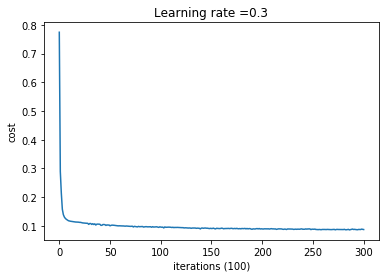

In [0]:
parameters = reg_model(train_X, train_Y)

This is 100% overfitting

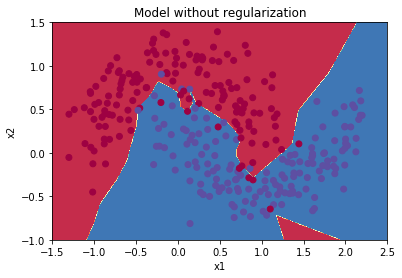

In [0]:
plt.title('Model without regularization')
axes = plt.gca()
axes.set_xlim([-1.5, 2.5])
axes.set_ylim([-1, 1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

Let's use L2 regularization. The idea behind L2 regularization is that we add an extra term when performing back prop

$ (\lambda * w)/m$

We have to use 'lambd' because 'lambda' is a reserved keyword in python

The motivation behind this is we will heavily penalize very large weights. We essentially want to prefer smaller weights. If you are a statistician, this is ridge regression

In [0]:
def compute_cost_with_regularization(A3, Y, parameters, lambd):

    m = Y.shape[1]
    W1 = parameters['W1']
    W2 = parameters['W2']
    W3 = parameters['W3']
    
    cross_entropy_cost = compute_cost(A3, Y)
    
    L2_regularization_cost = lambd * (np.sum(np.square(W1)) + np.sum(np.square(W2)) + np.sum(np.square(W3))) / (2 * m)
    
    cost = cross_entropy_cost + L2_regularization_cost
    
    return cost

In [0]:
def backward_propagation_with_regularization(X, Y, cache, lambd):

    m = X.shape[1]
    (Z1, A1, W1, b1, Z2, A2, W2, b2, Z3, A3, W3, b3) = cache
    
    dZ3 = A3 - Y    
    dW3 = 1. / m * np.dot(dZ3, A2.T) + (lambd * W3) / m
    db3 = 1. / m * np.sum(dZ3, axis=1, keepdims=True)
    
    dA2 = np.dot(W3.T, dZ3)
    dZ2 = np.multiply(dA2, np.int64(A2 > 0))
    dW2 = 1. / m * np.dot(dZ2, A1.T) + (lambd * W2) / m
    db2 = 1. / m * np.sum(dZ2, axis=1, keepdims=True)
    
    dA1 = np.dot(W2.T, dZ2)
    dZ1 = np.multiply(dA1, np.int64(A1 > 0))
    dW1 = 1. / m * np.dot(dZ1, X.T) + (lambd * W1) / m
    db1 = 1. / m * np.sum(dZ1, axis=1, keepdims=True)
    
    gradients = {'dZ3': dZ3, 'dW3': dW3, 'db3': db3, 'dA2': dA2,
                 'dZ2': dZ2, 'dW2': dW2, 'db2': db2, 'dA1': dA1, 
                 'dZ1': dZ1, 'dW1': dW1, 'db1': db1}
    
    return gradients

Cost after iteration 0: 0.8363759506216801
Cost after iteration 1000: 0.18582320538022273
Cost after iteration 2000: 0.17971469451594424
Cost after iteration 3000: 0.1783016377841377
Cost after iteration 4000: 0.17748250832001974
Cost after iteration 5000: 0.17709865043797512
Cost after iteration 6000: 0.17684147030813502
Cost after iteration 7000: 0.1766745043897679
Cost after iteration 8000: 0.1765866245114946
Cost after iteration 9000: 0.1764549843754177
Cost after iteration 10000: 0.17635770838784484
Cost after iteration 11000: 0.17633021074227373
Cost after iteration 12000: 0.17622109694187363
Cost after iteration 13000: 0.1762191988155857
Cost after iteration 14000: 0.17615715504829516
Cost after iteration 15000: 0.17610253286992325
Cost after iteration 16000: 0.17607960009217485
Cost after iteration 17000: 0.17599465699023445
Cost after iteration 18000: 0.17607178316073088
Cost after iteration 19000: 0.17598132203573733
Cost after iteration 20000: 0.17598902533422706
Cost after 

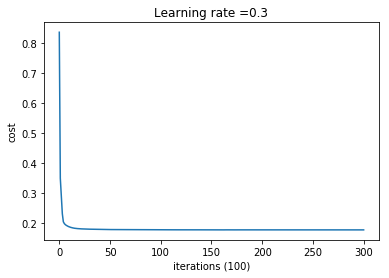

Accuracy: 0.94


In [0]:
parameters = reg_model(train_X, train_Y, lambd=0.7)
preds = predict(train_X, train_Y, parameters)

Pretty good. It seems to do a better job of generalizing

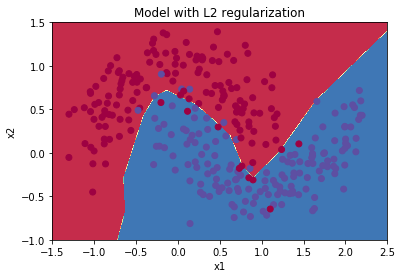

In [0]:
plt.title('Model with L2 regularization')
axes = plt.gca()
axes.set_xlim([-1.5, 2.5])
axes.set_ylim([-1, 1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

Let's use dropout. Dropout will randomly turn off neurons so the network doesn't have to rely on one neuron to do all of the work

In [0]:
def forward_propagation_with_dropout(X, parameters, keep_prob=0.5):
  
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
    # LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID
    Z1 = np.dot(W1, X) + b1
    A1 = relu(Z1)
    D1 = np.random.rand(A1.shape[0], A1.shape[1]) # Step 1: initialize matrix D1 = np.random.rand(..., ...)
    D1 = D1 < keep_prob # Step 2: convert entries of D1 to 0 or 1 (using keep_prob as the threshold)
    A1 = A1 * D1 # Step 3: shut down some neurons of A1
    A1 = A1 / keep_prob # Step 4: scale the value of neurons that haven't been shut down

    Z2 = np.dot(W2, A1) + b2
    A2 = relu(Z2)
    D2 = np.random.rand(A2.shape[0], A2.shape[1])
    D2 = D2 < keep_prob                           
    A2 = A2 * D2
    A2 = A2 / keep_prob

    Z3 = np.dot(W3, A2) + b3
    A3 = sigmoid(Z3)
    
    cache = (Z1, D1, A1, W1, b1, Z2, D2, A2, W2, b2, Z3, A3, W3, b3)
    
    return A3, cache

The back propagation is (I think) tricky but intuative. We just back propagate and shut down the same neurons we did in forward prop

In [0]:
def backward_propagation_with_dropout(X, Y, cache, keep_prob):

    
    m = X.shape[1]
    (Z1, D1, A1, W1, b1, Z2, D2, A2, W2, b2, Z3, A3, W3, b3) = cache
    
    dZ3 = A3 - Y
    dW3 = 1. / m * np.dot(dZ3, A2.T)
    db3 = 1. / m * np.sum(dZ3, axis=1, keepdims=True)
    
    dA2 = np.dot(W3.T, dZ3)
    dA2 = dA2 * D2              # Step 1: Apply mask D2 to shut down the same neurons as during the forward propagation
    dA2 = dA2 / keep_prob              # Step 2: Scale the value of neurons that haven't been shut down
    dZ2 = np.multiply(dA2, np.int64(A2 > 0))
    dW2 = 1. / m * np.dot(dZ2, A1.T)
    db2 = 1. / m * np.sum(dZ2, axis=1, keepdims=True)
    
    dA1 = np.dot(W2.T, dZ2)
    dA1 = dA1 * D1
    dA1 = dA1 / keep_prob
    dZ1 = np.multiply(dA1, np.int64(A1 > 0))
    dW1 = 1. / m * np.dot(dZ1, X.T)
    db1 = 1. / m * np.sum(dZ1, axis=1, keepdims=True)
    
    gradients = {'dZ3': dZ3, 'dW3': dW3, 'db3': db3,'dA2': dA2,
                 'dZ2': dZ2, 'dW2': dW2, 'db2': db2, 'dA1': dA1, 
                 'dZ1': dZ1, 'dW1': dW1, 'db1': db1}
    
    return gradients

Cost after iteration 0: 0.7470320575828212
Cost after iteration 1000: 0.40118971798395925


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in multiply
  """


Cost after iteration 2000: 0.4056695685738299
Cost after iteration 3000: nan
Cost after iteration 4000: nan
Cost after iteration 5000: nan
Cost after iteration 6000: nan
Cost after iteration 7000: nan
Cost after iteration 8000: nan
Cost after iteration 9000: nan
Cost after iteration 10000: nan
Cost after iteration 11000: nan
Cost after iteration 12000: nan
Cost after iteration 13000: nan
Cost after iteration 14000: nan
Cost after iteration 15000: nan
Cost after iteration 16000: nan
Cost after iteration 17000: nan
Cost after iteration 18000: nan
Cost after iteration 19000: nan
Cost after iteration 20000: nan
Cost after iteration 21000: nan
Cost after iteration 22000: nan
Cost after iteration 23000: nan
Cost after iteration 24000: nan
Cost after iteration 25000: nan
Cost after iteration 26000: nan
Cost after iteration 27000: nan
Cost after iteration 28000: nan
Cost after iteration 29000: nan
Cost after iteration 30000: nan


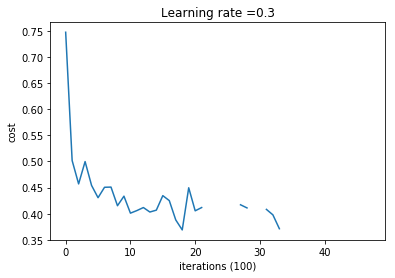

Accuracy: 0.94


In [0]:
parameters = reg_model(train_X, train_Y, keep_prob=0.5, learning_rate=0.3)
predictions_train = predict(train_X, train_Y, parameters)

This is also pretty good!

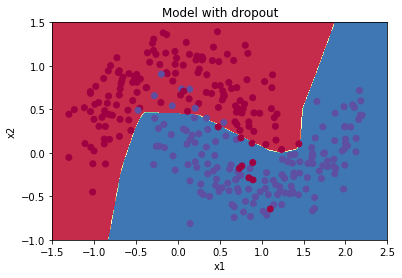

In [0]:
plt.title('Model with dropout')
axes = plt.gca()
axes.set_xlim([-1.5, 2.5])
axes.set_ylim([-1, 1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

This is just standard updating parameters

In [0]:
def update_parameters_with_gd(parameters, grads, learning_rate):

    L = len(parameters) // 2

    for l in range(L):
        parameters['W' + str(l + 1)] = parameters['W' + str(l + 1)] - learning_rate * grads['dW' + str(l + 1)]
        parameters['b' + str(l + 1)] = parameters['b' + str(l + 1)] - learning_rate * grads['db' + str(l + 1)]
        
    return parameters

Here we will generate the mini batches of random sizes

In [0]:
def random_mini_batches(X, Y, mini_batch_size = 64):

    m = X.shape[1]
    mini_batches = []
        
    #shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((1,m))

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:,k * mini_batch_size:(k + 1) * mini_batch_size]
        mini_batch_Y = shuffled_Y[:,k * mini_batch_size:(k + 1) * mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        end = m - mini_batch_size * math.floor(m / mini_batch_size)
        mini_batch_X = shuffled_X[:,num_complete_minibatches * mini_batch_size:]
        mini_batch_Y = shuffled_Y[:,num_complete_minibatches * mini_batch_size:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

Here we start to get to optimization. First we need a 'velocity' to we can use momentum. The motivation behind momentum is that as our model thinks it is going in the right direction to find the global optima, it will continue that direction the greater its momentum

In [0]:
def initialize_velocity(parameters):

    
    L = len(parameters) // 2
    v = {}
    
    # Initialize velocity
    for l in range(L):
        v['dW' + str(l + 1)] = np.zeros_like(parameters['W' + str(l+1)])
        v['db' + str(l + 1)] = np.zeros_like(parameters['b' + str(l+1)])
        
    return v

In [0]:
def update_parameters_with_momentum(parameters, grads, v, beta, learning_rate):

    L = len(parameters) // 2
    
    for l in range(L):

        v['dW' + str(l + 1)] = beta * v['dW' + str(l + 1)] + (1 - beta) * grads['dW' + str(l + 1)]
        v['db' + str(l + 1)] = beta * v['db' + str(l + 1)] + (1 - beta) * grads['db' + str(l + 1)]

        parameters['W' + str(l + 1)] = parameters['W' + str(l + 1)] - learning_rate * v['dW' + str(l + 1)]
        parameters['b' + str(l + 1)] = parameters['b' + str(l + 1)] - learning_rate * v['db' + str(l + 1)]

        
    return parameters, v

There is another form of optimization called RMSprop or root mean squared propogation. RMS prop will introduce another term, s, instead of v. This will behave very similarly to momentum from a visual point of view, but instead of continuing in the same direction, the propogation will find the root mean square of the gradients

We will not be using an implementation of RMSprop, but one day someone said 

![](https://i.imgur.com/6rZ8g8R.jpg)

and the adaptive moment estimation optimizer was born. It will use both momentum from the first algorithm and the estimation from RMSprop


In [0]:
def initialize_adam(parameters) :
    
    L = len(parameters) // 2
    v = {}
    s = {}
    
    for l in range(L):
        #Velocity for momentum
        v['dW' + str(l + 1)] = np.zeros_like(parameters['W' + str(l + 1)])
        v['db' + str(l + 1)] = np.zeros_like(parameters['b' + str(l + 1)])
        #S is formally the moving average of the squared gradient
        s['dW' + str(l+1)] = np.zeros_like(parameters['W' + str(l + 1)])
        s['db' + str(l+1)] = np.zeros_like(parameters['b' + str(l + 1)])
    
    return v, s

![](https://steemitimages.com/0x0/https://steemitimages.com/DQmZ4jPBcm6d4ZhEuHEquMcmJfiuXdQG2q6mJmxrKvi3xxs/image.png)

In [0]:
def update_parameters_with_adam(parameters, grads, v, s, t, learning_rate=0.01,
                                beta1=0.9, beta2=0.999, epsilon=1e-8):
    
    L = len(parameters) // 2
    v_corrected = {}
    s_corrected = {}
    
    # Perform Adam update on all parameters
    for l in range(L):
        v['dW' + str(l + 1)] = beta1 * v['dW' + str(l + 1)] + (1 - beta1) * grads['dW' + str(l + 1)]
        v['db' + str(l + 1)] = beta1 * v['db' + str(l + 1)] + (1 - beta1) * grads['db' + str(l + 1)]

        # Compute bias-corrected first moment estimate. Inputs: 'v, beta1, t'. Output: 'v_corrected'.
        v_corrected['dW' + str(l + 1)] = v['dW' + str(l + 1)] / (1 - np.power(beta1, t))
        v_corrected['db' + str(l + 1)] = v['db' + str(l + 1)] / (1 - np.power(beta1, t))

        # Moving average of the squared gradients. Inputs: 's, grads, beta2'. Output: 's'.
        s['dW' + str(l + 1)] = beta2 * s['dW' + str(l + 1)] + (1 - beta2) * np.power(grads['dW' + str(l + 1)], 2)
        s['db' + str(l + 1)] = beta2 * s['db' + str(l + 1)] + (1 - beta2) * np.power(grads['db' + str(l + 1)], 2)

        # Compute bias-corrected second raw moment estimate. Inputs: 's, beta2, t'. Output: 's_corrected'.
        s_corrected['dW' + str(l + 1)] = s['dW' + str(l + 1)] / (1 - np.power(beta2, t))
        s_corrected['db' + str(l + 1)] = s['db' + str(l + 1)] / (1 - np.power(beta2, t))

        # Update parameters. Inputs: 'parameters, learning_rate, v_corrected, s_corrected, epsilon'. Output: 'parameters'.
        parameters['W' + str(l + 1)] = parameters['W' + str(l + 1)] - learning_rate * v_corrected['dW' + str(l + 1)] / np.sqrt(s_corrected['dW' + str(l + 1)] + epsilon)
        parameters['b' + str(l + 1)] = parameters['b' + str(l + 1)] - learning_rate * v_corrected['db' + str(l + 1)] / np.sqrt(s_corrected['db' + str(l + 1)] + epsilon)

    return parameters, v, s

Now, let's see how each one does

Cost after epoch 0: 0.841090
Cost after epoch 1000: 0.540112
Cost after epoch 2000: 0.432481
Cost after epoch 3000: 0.424872
Cost after epoch 4000: 0.449423
Cost after epoch 5000: 0.276268
Cost after epoch 6000: 0.253836
Cost after epoch 7000: 0.398823
Cost after epoch 8000: 0.311545
Cost after epoch 9000: 0.387525


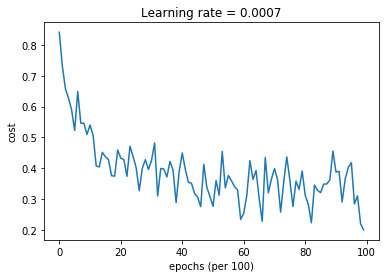

In [0]:
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = opt_model(train_X, train_Y, layers_dims, optimizer='gd')

Not bad, really

Accuracy: 0.8666666666666667


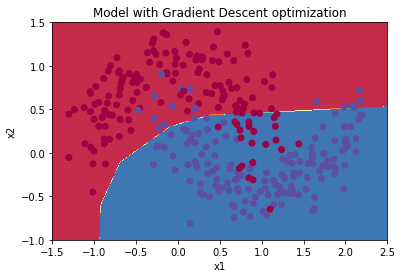

In [0]:
predictions = predict(train_X, train_Y, parameters)

plt.title('Model with Gradient Descent optimization')
axes = plt.gca()
axes.set_xlim([-1.5, 2.5])
axes.set_ylim([-1, 1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

How about momentum?

Cost after epoch 0: 0.561851
Cost after epoch 1000: 0.489214
Cost after epoch 2000: 0.513810
Cost after epoch 3000: 0.480378
Cost after epoch 4000: 0.554982
Cost after epoch 5000: 0.268460
Cost after epoch 6000: 0.379188
Cost after epoch 7000: 0.337964
Cost after epoch 8000: 0.389305
Cost after epoch 9000: 0.362110
Cost after epoch 10000: 0.401617
Cost after epoch 11000: 0.319881
Cost after epoch 12000: 0.360850
Cost after epoch 13000: 0.501008
Cost after epoch 14000: 0.210700
Cost after epoch 15000: 0.423821
Cost after epoch 16000: 0.286184
Cost after epoch 17000: 0.236205
Cost after epoch 18000: 0.384409
Cost after epoch 19000: 0.282531
Cost after epoch 20000: 0.469842
Cost after epoch 21000: 0.143945
Cost after epoch 22000: 0.205085
Cost after epoch 23000: 0.168939
Cost after epoch 24000: 0.477325
Cost after epoch 25000: 0.167354
Cost after epoch 26000: 0.353027
Cost after epoch 27000: 0.261523
Cost after epoch 28000: 0.199373
Cost after epoch 29000: 0.217279


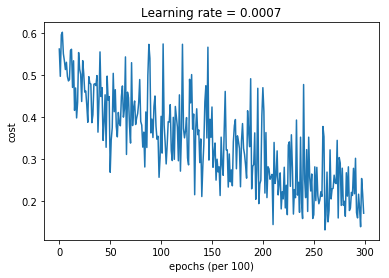

In [0]:
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = opt_model(train_X, train_Y, layers_dims, beta=0.9, num_epochs=30000, optimizer='momentum')

Seems like it was never really able to find a good direction to go

Accuracy: 0.9233333333333333


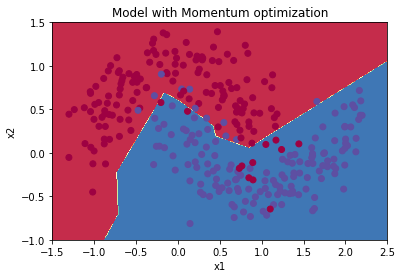

In [0]:
predictions = predict(train_X, train_Y, parameters)

plt.title('Model with Momentum optimization')
axes = plt.gca()
axes.set_xlim([-1.5, 2.5])
axes.set_ylim([-1, 1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

Last but the opposite of least, adam

Cost after epoch 0: 0.696511
Cost after epoch 1000: 0.171906
Cost after epoch 2000: 0.165086
Cost after epoch 3000: 0.133156
Cost after epoch 4000: 0.165320
Cost after epoch 5000: 0.108941
Cost after epoch 6000: 0.051629
Cost after epoch 7000: 0.133816
Cost after epoch 8000: 0.103390
Cost after epoch 9000: 0.107934


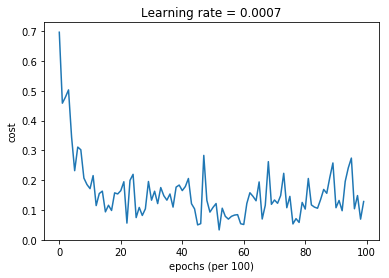

In [0]:
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = opt_model(train_X, train_Y, layers_dims, num_epochs=10000, optimizer='adam')

This is the best in the whole notebook, beating out dropout. The model was able to make a pretty good generalization, and if we look back at the complexity of the optimizer model compared to the regularization model, the optimizer is much much simpler. So we were able to make a better prediction on a simpler model in a shorter amount of time using optimization. This isn't to say 

Accuracy: 0.94


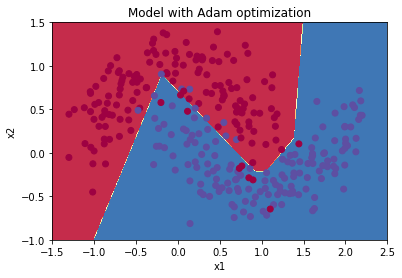

In [0]:
predictions = predict(train_X, train_Y, parameters)

plt.title('Model with Adam optimization')
axes = plt.gca()
axes.set_xlim([-1.5, 2.5])
axes.set_ylim([-1, 1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

Additional reading: https://towardsdatascience.com/only-numpy-implementing-and-comparing-gradient-descent-optimization-algorithms-google-brains-8870b133102b
